In [28]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

data = torch.tensor([0., 1., 10., 11., 12.])

K = 2  # Fixed number of components.

def model(data):
    # data.shape = torch.Size([5])
    # Global parameters.
    weights = pyro.param('weights', torch.ones(K) / K, constraint=constraints.simplex)
    locs = pyro.param('locs', 10 * torch.randn(K))
    scale = pyro.param('scale', torch.tensor(0.5), constraint=constraints.positive)
    with pyro.iarange('data'):
        # Local variables.
        assignment = pyro.sample('assignment',
                                 dist.Categorical(weights).expand_by([len(data)]))
        # assignment.size() = torch.Size([2, 5])
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

def guide(data):
    with pyro.iarange('data'):
        # Local parameters.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        # assignment_probs.size() = torch.Size([2, 5])
        pyro.sample('assignment', dist.Categorical(assignment_probs))
        

optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
inference = SVI(model, config_enumerate(guide, 'parallel'), optim,
                loss=TraceEnum_ELBO(max_iarange_nesting=1))

In [29]:
pyro.set_rng_seed(1)      # Set seed to make results reproducible.
pyro.clear_param_store()  # Clear stale param values.

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
inference.loss(model, guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500 if not smoke_test else 2):
    loss = inference.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

ind: None
ind: None

ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.ind: None
.

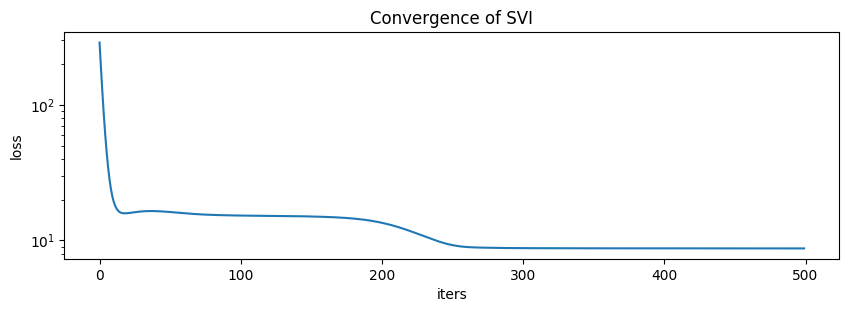

In [3]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

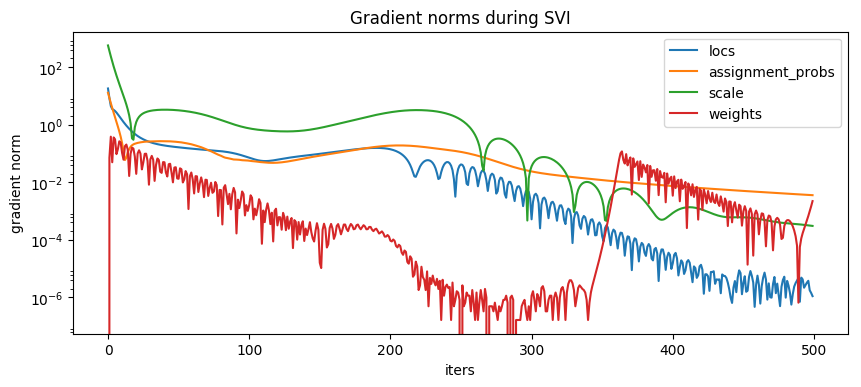

In [4]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [5]:

weights = pyro.param('weights')
locs = pyro.param('locs')
scale = pyro.param('scale')
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.6004859  0.39951405]
locs = [10.999848   0.5001591]
scale = 0.708275258541


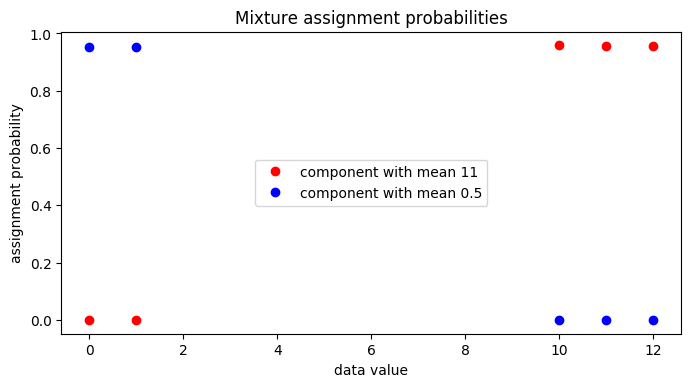

In [6]:
assignment_probs = pyro.param('assignment_probs')
pyplot.figure(figsize=(8, 4), dpi=100).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center');

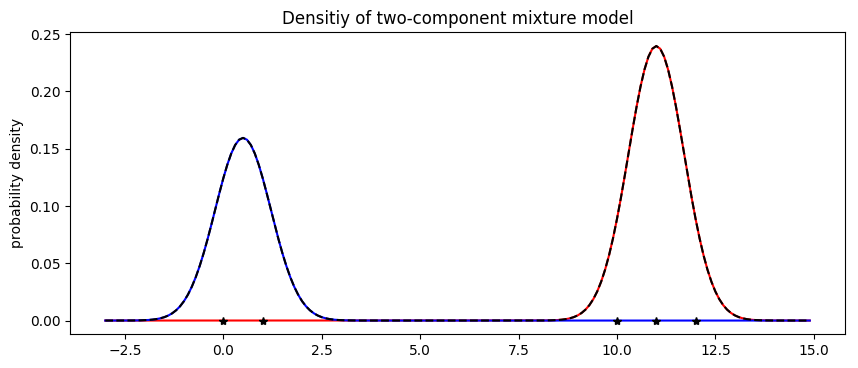

In [7]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density');